# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [211]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [212]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [213]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 13, 
                               #ngram_range=(1, 2), 
                               #token_pattern=r'\b\w+\b',
                               binary=True,
                               alternate_sign=True)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count('!')
    toxic_data['excl_pct'] = toxic_data['excl_count'] / toxic_data['word_count']
    toxic_data['upper_ratio'] = toxic_data['comment_text'].str.count(r'[A-Z]') / toxic_data['word_count']
    toxic_data['dir_response'] = toxic_data['comment_text'].str.count('you') + toxic_data['comment_text'].str.count('You')
    toxic_data['ret_count'] = toxic_data['comment_text'].str.count('\n')
    
    X_quant_features = toxic_data[[#"word_count", 
                                   #"punc_count", 
                                   #"excl_count", 
                                   "upper_ratio", 
                                   "dir_response",
                                   "ret_count"
                                  ]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [214]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_train.csv', my_random_seed=19)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [215]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6372, 'TN': 58987, 'FP': 55621, 'FN': 6676, 'Accuracy': 0.5119931691420693, 'Precision': 0.10278579839659316, 'Recall': 0.4883507050889025, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [216]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10641, 'TN': 112951, 'FP': 1657, 'FN': 2407, 'Accuracy': 0.9681644419377076, 'Precision': 0.8652626443324117, 'Recall': 0.8155272838749233, 'desc': 'svm_train'}


### MODEL: logistic regression

In [217]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10570, 'TN': 112914, 'FP': 1694, 'FN': 2478, 'Accuracy': 0.9673184182490443, 'Precision': 0.8618721461187214, 'Recall': 0.8100858369098712, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [218]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 11420, 'TN': 98711, 'FP': 15897, 'FN': 1628, 'Accuracy': 0.8627169894090367, 'Precision': 0.4180546912179229, 'Recall': 0.875229920294298, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [219]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', alpha=1.0e-5)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 10369, 'TN': 112463, 'FP': 2145, 'FN': 2679, 'Accuracy': 0.9622109419063734, 'Precision': 0.8285919769857759, 'Recall': 0.7946811771919068, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [220]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0e+4)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 6889, 'TN': 114309, 'FP': 299, 'FN': 6159, 'Accuracy': 0.9494109168390048, 'Precision': 0.9584028937117418, 'Recall': 0.5279736358062538, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [221]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=15, random_state=0, bootstrap=False)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13048, 'Neg': 114608, 'TP': 444, 'TN': 114608, 'FP': 0, 'FN': 12604, 'Accuracy': 0.9012659021119258, 'Precision': 1.0, 'Recall': 0.034028203556100554, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

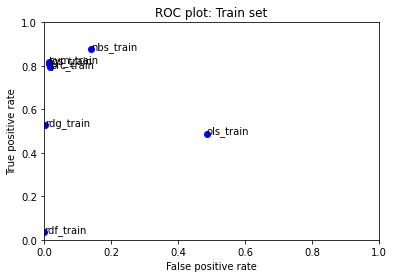

In [222]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train
]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: Train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [223]:
#FALSE NEGATIVES
ols_predictions = ols.predict(X_train)

In [224]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 0):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false negatives:
226
Fuck you bitch! I will go to your house and kill you with my gun as well! Prepare to die!
* * * * * * * * * 
782
Vadalize? 

What did I vandalize you fool? ya admin are lyke Bush alwayz keeping us Niggers down! now tell me what I did, so I can try ta get your admin removed.
* * * * * * * * * 
1158
Coward 

Just like a Bangladeshi. Couldn't even give me a response, could you?

I tried being polite, didn't I? I tried being civil. But you people are all the same.

I'm in Bangladesh now, you know. As I said. Dacca, to be precise. And you've been awfully free with information about yourself.

You wouldn't want anything to happen to your filthy Bangladeshi family, would you, bucko?

Answer me like a man, or American justice is gonna get real over here. Or don't you want to admit that you're just leeching off of the goodwill of the land of the free and the home of the brave?
* * * * * * * * * 
1615
Che

Stop being such a jerk, read the cited material below.  S

15747
You have no friends in real life, what makes you think anyone on the internet will like you?  Take the hint, you're an a-hole.
* * * * * * * * * 
15915
"

 Rhobite a hypocrite? 

Below is what  wrote on a page discussing blocking ""personal attacks."" Bold added for emphasis.

I'm slightly against removing personal attacks. There are too many instances of revert wars on talk pages. Also, people should not remove personal attacks that are directed against them - ask someone else. There are too many instances of people in a dispute editing each others' comments. Rhobite 18:21, Jun 23, 2005 (UTC) 

Is Rhobite a hypocrite? He warned me about a personal attack (which I admit I probably could have worded better). I removed it. I then probably crossed the line making a comment about him (I was just a little upset with him trying to muscle me... See above). He then removed those comments and blocked me for a reason which he never warned me. Hypocrite? I think so.  "
* * * * * * * * * 
16

23376
The problem was some idiot made ridiculous edits to the infobox. I'll try to fix it.
* * * * * * * * * 
23475
, which are not covered by WP:MOSISLAM mentioned by the dyke with the chopped off dick.}}
* * * * * * * * * 
23837
REMOVING CUM STAINS FROM THE FAGGOTs THAT JACK OFF HERE
* * * * * * * * * 
23846
Buffalo Bill THE VANDAL
YOU MY FRIEND ARE LITTLE MORE THAN A VANDAL AND AN EGOCENTRIC JERK
* * * * * * * * * 
24616
serious, i mean what the fuck is this? Fucking Prison fucking camp? Please fucking unblock me
* * * * * * * * * 
24680
stop pretending 

Stop pretending to be cool.
I don't really care what you do. Go ahead and ban me, I can change my IP in less than 5 seconds or I can use 1 of the thousands of spoofs, vpns, etc, etc. I don't even have to close my browser to do it.
You should also know that even if you vandalize my IP user page, I'm still not going to read your reply. Do yourself a favor and go fuck your wife before somebody else does.

 1, 2, 3, 4. Let's have an ed

31101
From the rest of the world 
go fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuc

37282
I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have no penis, I have n

41855
Eat a Dick, Lucasbfr 

Yo . i'm [[User:Cool 97|Cool 97]

I know that you tryin' to Block my Page. And I Don't Fuckin' Like that.

your shit is GARBAGE! yeah you heard me!
I Do Have Rights to Upload Pictures!!!

Motherfuckers Like You Don't Belong to Wiipedia. 

By the way... Eat a Dick, Lucasbfr
* * * * * * * * * 
42135
.
.SO WOT, YOURE NOT GANNA RESPOND TO MY MOTHERFUCKING DISS. COME ON, DONT PUSSY. I CALLED YOU OUT. SO NOW IT'S YOURE TURN AND DONT MESSAGE WITH THAT FUCKING NERD BULLSHIT GET AT ME LIKE A FUCKING MAN DOES NIGGA CUZ ITS ON DAWG
* * * * * * * * * 
42268
yes, and lets also delete or change any articles that are unislamic, such as the ones about homosexuality, christianity and judaism and other religions, and actually lets make it so everyone has to post islamic prayers 5 times a day, and if any females post out of turn than we will e-stone them, or give them 200 e-lashes, and while we are at it why not just permaban everyone who won't convert to islam?  Screw you bu

48529
"

 haiti 
hey, can you explain what the wikipedia is when you forbid people to write? My aim is to point out that it is ""good and kind type of superpower,""

I, a man from the Czech Republic, post-communist country does not like to see if the history interpreted unilaterally, and in order to become a meliorate, and the other completely discredit.

To you in the U.S. is raising fanatically that do not even think that your country stinks?

Indeed, just enough so you start heiling as nazist, and you both Germany in 1939.

Fanatics are already on enough. 

Then not understand why you are not best friends with the most painful of dictatorships, such as in North Korea

indeed, he is not surprised that that your fascist state was repeatedly elected několirktá as the biggest problem in the path to world peace

actually, you stupid, patriotic, manipulative bastards should kill, burn, your entire floor level to the ground and even sprinkle with salt ... or one day destroy the entire worl

53182
Welcome, Korean assh*le's page.
Why don't you enjoy licking Korean assh*le!
* * * * * * * * * 
54330
fuck off mifter 

that was a great edit!!!! it was about icecream!!!!
* * * * * * * * * 
55131
Kiss meee arse 

Like its SOOO convincing what you wrote. How about stick a stick up your fat assk.
* * * * * * * * * 
55337
mac 

only faggots and dumb housewives use macs. which one are you?
* * * * * * * * * 
55709
Images I've taken will not be removed from my user page 

This is ridiculous. I am not going to be bowing to the contention that I am not allowed to use images, that I myself acquired no less, on my user page. Fuck policy. Policy is made by social people who have no better thing to do than constantly bicker amongst themselves about. Policy is inherently flawed because it's made by people who dedicate themselves to a bureaucracy. Under copyright law, I am more than well within MY FUCKING RIGHTS to use these fair-use images of MY taking in this way. Wikipedia policy should be

63617
I'm not one of your students. Talk to me like an adult or shut up.
* * * * * * * * * 
63644
Dick Head 

José Eduardo dos Santos

What seems to be the problem with your friend Dos Santos
* * * * * * * * * 
63866
"Reply ==
Hello 
""ThePeg"", you do yourself a grave injustice. There are no ""Stupid questions"", only ""Stupid answers"". Cheers   

== "
* * * * * * * * * 
64140
it is a constructive edit you idiot, every kid of every age should know that santa claus is fucking fictional. ever since i first heard of santa claus i knew that he was fictional, my parents didn't give me any delusions and if they had, i would've laughed in their faces and said it isn't logical because it fucking isn't. every kid should be logical just like i was and every kid should be able to logically fucking infer that there is no fucking santa claus in the real human universe.
* * * * * * * * * 
64876
Ima gona slash your tires!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

What the fuck is your problem you little school

74324
Please refrain from unmaking unconstructive edits to Wikipedia, as you did at Tim Pawlenty. Your edits appear to constitute whitewashing and have been reverted or removed. If you would like to experiment, please use the litterbox. Thank you.

You're a dirt-muffling little suck turd with no Tosh.0 to guzzle down tonight. Fuck off.
* * * * * * * * * 
74547
About your concerns of Scooby-Doo The Dread of Chicago Page 

MIND YOUR OWN BUSINESS!! I am trying to propose an Idea and I can't do it on the Ideas Wiki because of a voice actor obsessed maniac! Please leave the article alone until fans blog it on other sites
* * * * * * * * * 
74808
AGAIN
YOU ARE ALL N3GROS, YAH I AM GOING TO HAVE S3X WITH YOU NEGROS, YOU CAN GO ON YOUR MAMA BR3AST AND, N3GROS USERS LIKE MCDONALD AND AREASEVEN SNJONES, YOU CAN GO TO JAIL WITHOUT HUNGER. YAH YAH YAH N3GROS.
* * * * * * * * * 
74990
BASEBALLS BUGS IS AN UGLY IGNORANT FOOL
* * * * * * * * * 
75029
You are one goddamn ugly son of a bitch.
* * * * *

86016
Don't think you can get away with fucking me over like that, you asshole
* * * * * * * * * 
86025
Because if you do, I will continue to cry like a little bitch and report you to the higher Wikithorities!
* * * * * * * * * 
87625
Yeah, Bullzeye's hired a legion of male prostitutes and he doesn't want all that money to go to waste.
* * * * * * * * * 
87829
For being a massive faggot
* * * * * * * * * 
88851
"

 I'm just helping the reader of Wikipedia not see a medal table all messy and without logical organization. And this ""bronze medal first, gold second and silver third"" or ""mixed date order"" don't help nobody. I suggest you ignore this crazy consensus.   "
* * * * * * * * * 
88900
How about leaving the dishonourable epithet up? If not, I can always bombard the article with multiple sockpuppets. Should keep it interesting, n'est pas. Goddamn traitors.24.224.214.165
* * * * * * * * * 
89659
I don't give a fuck about the personal attack shit.  The Pats win 35-21.  Ohh ya, wou

106808
UNBLOCK ME NOW, I DID NOTHING WRONG. UNBLOCK ME NOW, RIGHT NOW YOU FUCKING BASTARD.
* * * * * * * * * 
107196
"

YOU'VE BEEN HIT BY THE

|^^^^^^^^^^^^|
|BEAUTIFUL truck | '|"""""";.., ___.
|_..._...______===|= _|__|..., ] |
""(@ )'(@ )""""""""*|(@ )(@ )*****(@

ONCE YOU'VE BEEN HIT, YOU HAVE TO HIT 8 Beautiful People IF YOU GET HIT AGAIN YOU'LL KNOW YOU'RE REALLY BEAUTIFUL! IF YOU BRAKE THE CHAIN, YOU'LL BE CURSED WITH UGLYNESS FOR 10 YEARS SO PASS IT HIT WHO EVER YOU THINK IS BEAUTIFUL!"
* * * * * * * * * 
107430
Also, keep in mind that Wikipedians are quite adept at thinking they are righteous and brilliant for editing an online junkyard.  My suggestion would be to move on to a better website without the shitty corruption and moronic interludes.  67.176.98.94
* * * * * * * * * 
108953
What the hell is with everybody making Etna articles?
* * * * * * * * * 
109045
FUCK YOU  

the subject says it all bitch.
 (24.23.87.244  )
* * * * * * * * * 
109474
Islam is the fastest growing

125005
FUCK U ALL 

FUCK U ALL
* * * * * * * * * 
125107
Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated.
* * * * * * * * * 
125309
Too much curio$ity 

Plea$e tell me that you're gay, man ;P
* * * * * * * * * 
125637
IM A FUCKING ASSHOLE!!
* * * * * * * * * 
125721
HOLA FUCKER 

HOLA FUCKER
* * * * * * * * * 
126656
i anal rape little iraqie children while i type crap in on wikipedia.
* * * * * * * * * 


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [225]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1516, 'TN': 14759, 'FP': 13979, 'FN': 1661, 'Accuracy': 0.5099483001723327, 'Precision': 0.09783801226202, 'Recall': 0.4771797293043752, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [226]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2179, 'TN': 27696, 'FP': 1042, 'FN': 998, 'Accuracy': 0.9360802130659565, 'Precision': 0.6764979819931698, 'Recall': 0.6858671702864337, 'desc': 'svm_test'}


### MODEL: logistic regression

In [227]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2190, 'TN': 27721, 'FP': 1017, 'FN': 987, 'Accuracy': 0.9372082093059689, 'Precision': 0.6828811973807296, 'Recall': 0.6893295561850803, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [228]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2525, 'TN': 24558, 'FP': 4180, 'FN': 652, 'Accuracy': 0.8485978380072067, 'Precision': 0.37658463832960476, 'Recall': 0.794774944916588, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [229]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 2164, 'TN': 27650, 'FP': 1088, 'FN': 1013, 'Accuracy': 0.934168886103713, 'Precision': 0.6654366543665436, 'Recall': 0.6811457349700976, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [230]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 1565, 'TN': 28617, 'FP': 121, 'FN': 1612, 'Accuracy': 0.9456995143349523, 'Precision': 0.928232502965599, 'Recall': 0.49260308467107333, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [231]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3177, 'Neg': 28738, 'TP': 63, 'TN': 28738, 'FP': 0, 'FN': 3114, 'Accuracy': 0.9024283252389159, 'Precision': 1.0, 'Recall': 0.019830028328611898, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

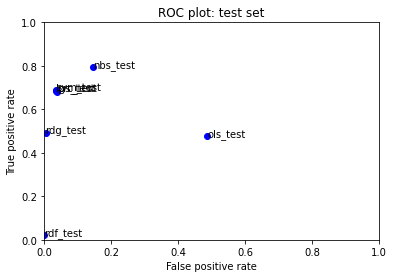

In [233]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test
       ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [234]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/geoff/PycharmProjects/machine_learning_assignment1/toxic_comments/toxiccomments_test.csv', my_random_seed=19, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 8192)
Look at a few rows of the new quantitative features: 
   upper_ratio  dir_response  ret_count
0     0.055556             5          0
1     0.538462             0          2
2     0.250000             0          4
3     0.105263             3          0
4     0.142857             0  

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [235]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.1929761562769319


In [236]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count,excl_pct,upper_ratio,dir_response,ret_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,0.0,0.055556,5,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,0.0,0.538462,0,2
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0.0,0.250000,0,4
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,0.0,0.105263,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,0.0,0.142857,0,0


In [237]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [238]:
my_submission.shape

(153164, 2)

In [239]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/geoff/Desktop/New_School/Semester_5/Machine_Learning/assignment1/iterations/toxiccomments_iter4_gstorr.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation